# Introduction
Restaurants operate in the tricky business of serving perishable products. Accurately forecasting customer demand is essential for increasing profits, since it allows for reduction of food wastage and labor costs. With forecasts, managers can predict how much perishable inventory to keep on hand and predict how much food should be prepped at the beginning of each day. Managers can also schedule sufficient staff according to forecasts to ensure customer satisfaction during normal and peak hours. Increased scheduling efficiency also benefits the staff because managers can more easily ensure their staff are assigned enough shifts for their livelihood and are not being overworked.

In this project, I create Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX) and Bayesian Structural Time Series (BSTS) models to forecast the daily number of visitors at restaurants. This notebook is part 1 of a two-notebook project on the [Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting) dataset provided by Recruit Holdings, and in this notebook I perform exploratory data analysis and data cleaning on the dataset. [Part 2](https://github.com/michellekli/visitor-forecasting/blob/master/visitor-forecasting-part2.ipynb) covers data preparation, time series analysis, and modeling.

The minimum viable product (MVP) for this project is a Python script that takes as input a store in the dataset and outputs a forecast of daily visitors for that store.

# Data Set

## Features
> ### air_reserve.csv
>
> This file contains reservations made in the air system. Note that the reserve_datetime indicates the time when the reservation was created, whereas the visit_datetime is the time in the future where the visit will occur.
>
> * air_store_id - the restaurant's id in the air system
> * visit_datetime - the time of the reservation
> * reserve_datetime - the time the reservation was made
> * reserve_visitors - the number of visitors for that reservation
>
> ### hpg_reserve.csv
>
> This file contains reservations made in the hpg system.
>
> * hpg_store_id - the restaurant's id in the hpg system
> * visit_datetime - the time of the reservation
> * reserve_datetime - the time the reservation was made
> * reserve_visitors - the number of visitors for that reservation
>
> ### air_store_info.csv
>
> This file contains information about select air restaurants. Column names and contents are self-explanatory.
>
> * air_store_id
> * air_genre_name
> * air_area_name
> * latitude
> * longitude
>
> Note: latitude and longitude are the latitude and longitude of the area to which the store belongs
>
> ### hpg_store_info.csv
>
> This file contains information about select hpg restaurants. Column names and contents are self-explanatory.
>
> * hpg_store_id
> * hpg_genre_name
> * hpg_area_name
> * latitude
> * longitude
>
> Note: latitude and longitude are the latitude and longitude of the area to which the store belongs
>
> ### store_id_relation.csv
>
> This file allows you to join select restaurants that have both the air and hpg system.
>
> * hpg_store_id
> * air_store_id
>
> ### air_visit_data.csv
>
> This file contains historical visit data for the air restaurants.
>
> * air_store_id
> * visit_date - the date
> * visitors - the number of visitors to the restaurant on the date
>
> ### sample_submission.csv
>
> This file shows a submission in the correct format, including the days for which you must forecast.
>
> * id - the id is formed by concatenating the air_store_id and visit_date with an underscore
> * visitors- the number of visitors forecasted for the store and date combination
>
> ### date_info.csv
>
> This file gives basic information about the calendar dates in the dataset.
>
> * calendar_date
> * day_of_week
> * holiday_flg - is the day a holiday in Japan
> 
> [Source: Recruit Holdings, Dataset Creator](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set(font_scale=1.2)
import hvplot.pandas
import geoviews as gv

import vfplot as vfp
import vfdata as vfd

# Load data
These data files are not included in the repository and can be downloaded from [Kaggle](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/).

In [2]:
air_visit_data_df = pd.read_csv('data/visitor-forecasting/air_visit_data.csv')
air_visit_data_df.head()

air_store_id  visit_date  visitors
0  air_ba937bf13d40fb24  2016-01-13        25
1  air_ba937bf13d40fb24  2016-01-14        32
2  air_ba937bf13d40fb24  2016-01-15        29
3  air_ba937bf13d40fb24  2016-01-16        22
4  air_ba937bf13d40fb24  2016-01-18         6

In [3]:
# no null values
air_visit_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
air_store_id    252108 non-null object
visit_date      252108 non-null object
visitors        252108 non-null int64
dtypes: int64(1), object(2)
memory usage: 5.8+ MB


In [4]:
air_store_info_df = pd.read_csv('data/visitor-forecasting/air_store_info.csv')
air_store_info_df.head()

air_store_id  air_genre_name                 air_area_name  \
0  air_0f0cdeee6c9bf3d7  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
1  air_7cc17a324ae5c7dc  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
2  air_fee8dcf4d619598e  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
3  air_a17f0778617c76e2  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
4  air_83db5aff8f50478e  Italian/French  Tōkyō-to Minato-ku Shibakōen   

    latitude   longitude  
0  34.695124  135.197852  
1  34.695124  135.197852  
2  34.695124  135.197852  
3  34.695124  135.197852  
4  35.658068  139.751599

In [5]:
# no null values
air_store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
air_store_id      829 non-null object
air_genre_name    829 non-null object
air_area_name     829 non-null object
latitude          829 non-null float64
longitude         829 non-null float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


In [6]:
hpg_store_info_df = pd.read_csv('data/visitor-forecasting/hpg_store_info.csv')
hpg_store_info_df.head()

hpg_store_id  hpg_genre_name                  hpg_area_name  \
0  hpg_6622b62385aec8bf  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
1  hpg_e9e068dd49c5fa00  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
2  hpg_2976f7acb4b3a3bc  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
3  hpg_e51a522e098f024c  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
4  hpg_e3d0e1519894f275  Japanese style  Tōkyō-to Setagaya-ku Taishidō   

    latitude   longitude  
0  35.643675  139.668221  
1  35.643675  139.668221  
2  35.643675  139.668221  
3  35.643675  139.668221  
4  35.643675  139.668221

In [7]:
# no null values
hpg_store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
hpg_store_id      4690 non-null object
hpg_genre_name    4690 non-null object
hpg_area_name     4690 non-null object
latitude          4690 non-null float64
longitude         4690 non-null float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB


In [8]:
store_id_relation_df = pd.read_csv('data/visitor-forecasting/store_id_relation.csv')
store_id_relation_df.head()

air_store_id          hpg_store_id
0  air_63b13c56b7201bd9  hpg_4bc649e72e2a239a
1  air_a24bf50c3e90d583  hpg_c34b496d0305a809
2  air_c7f78b4f3cba33ff  hpg_cd8ae0d9bbd58ff9
3  air_947eb2cae4f3e8f2  hpg_de24ea49dc25d6b8
4  air_965b2e0cf4119003  hpg_653238a84804d8e7

In [9]:
# no null values
store_id_relation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
air_store_id    150 non-null object
hpg_store_id    150 non-null object
dtypes: object(2)
memory usage: 2.4+ KB


# Merge data sets
There are several data files related to restaurants and their daily number of visitors. I explore each file to see how they are related and see which ones could be helpful for forecasting.

## Investigate related hpg and air store ids

In [10]:
hpg_store_info_df['hpg_store_id'].isin(store_id_relation_df['hpg_store_id']).sum()

63

In [11]:
store_id_relation_df['hpg_store_id'].isin(hpg_store_info_df['hpg_store_id']).sum()

63

In [12]:
hpg_store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
hpg_store_id      4690 non-null object
hpg_genre_name    4690 non-null object
hpg_area_name     4690 non-null object
latitude          4690 non-null float64
longitude         4690 non-null float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB


In [13]:
hpg_store_info_df.nunique()

hpg_store_id      4690
hpg_genre_name      34
hpg_area_name      119
latitude           129
longitude          129
dtype: int64

In [14]:
store_id_relation_df.nunique()

air_store_id    150
hpg_store_id    150
dtype: int64

Only 63 hpg stores out of 4690 are related to an air store through store_id_relation.

In [15]:
air_store_info_df['air_store_id'].isin(store_id_relation_df['air_store_id']).sum()

150

In [16]:
store_id_relation_df['air_store_id'].isin(air_store_info_df['air_store_id']).sum()

150

In [17]:
air_store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
air_store_id      829 non-null object
air_genre_name    829 non-null object
air_area_name     829 non-null object
latitude          829 non-null float64
longitude         829 non-null float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


In [18]:
air_store_info_df.nunique()

air_store_id      829
air_genre_name     14
air_area_name     103
latitude          108
longitude         108
dtype: int64

In [19]:
store_id_relation_df.nunique()

air_store_id    150
hpg_store_id    150
dtype: int64

Only 150 air stores out of 829 are related to a hpg store through store_id_relation. Since we only have visitor data for air stores, it makes sense to supplement the data only with hpg stores that can be linked to an air store. However, for the minimum viable product (MVP) I am trying to forecast visitor counts with only the visitor count data, so I will not merge any hpg store info at this time.

## Investigate related air store info and air store visit data

In [20]:
air_store_info_df['air_store_id'].isin(air_visit_data_df['air_store_id']).sum()

829

In [21]:
air_visit_data_df['air_store_id'].isin(air_store_info_df['air_store_id']).sum()

252108

In [22]:
air_store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
air_store_id      829 non-null object
air_genre_name    829 non-null object
air_area_name     829 non-null object
latitude          829 non-null float64
longitude         829 non-null float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


In [23]:
air_visit_data_df.nunique()

air_store_id    829
visit_date      478
visitors        204
dtype: int64

In [24]:
air_visit_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
air_store_id    252108 non-null object
visit_date      252108 non-null object
visitors        252108 non-null int64
dtypes: int64(1), object(2)
memory usage: 5.8+ MB


In [25]:
air_visit_data_df.nunique()

air_store_id    829
visit_date      478
visitors        204
dtype: int64

Every air store in air_visit_data has an entry in air_store_info and there is at least one entry in air_visit_data for every air store in air_store_info. I will merge these two data sets for ease of exploration.

In [26]:
# final, combined dataframe
df = air_visit_data_df.merge(air_store_info_df, on='air_store_id', how='inner')
df.head()

air_store_id  visit_date  visitors air_genre_name  \
0  air_ba937bf13d40fb24  2016-01-13        25     Dining bar   
1  air_ba937bf13d40fb24  2016-01-14        32     Dining bar   
2  air_ba937bf13d40fb24  2016-01-15        29     Dining bar   
3  air_ba937bf13d40fb24  2016-01-16        22     Dining bar   
4  air_ba937bf13d40fb24  2016-01-18         6     Dining bar   

                  air_area_name   latitude   longitude  
0  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599  
1  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599  
2  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599  
3  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599  
4  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599

In [27]:
assert df.shape[0] == air_visit_data_df.shape[0]
assert df.shape[1] == (air_visit_data_df.shape[1] + air_store_info_df.shape[1] - 1)

# Exploration

In [28]:
df.head()

air_store_id  visit_date  visitors air_genre_name  \
0  air_ba937bf13d40fb24  2016-01-13        25     Dining bar   
1  air_ba937bf13d40fb24  2016-01-14        32     Dining bar   
2  air_ba937bf13d40fb24  2016-01-15        29     Dining bar   
3  air_ba937bf13d40fb24  2016-01-16        22     Dining bar   
4  air_ba937bf13d40fb24  2016-01-18         6     Dining bar   

                  air_area_name   latitude   longitude  
0  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599  
1  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599  
2  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599  
3  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599  
4  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599

In [29]:
# no null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 7 columns):
air_store_id      252108 non-null object
visit_date        252108 non-null object
visitors          252108 non-null int64
air_genre_name    252108 non-null object
air_area_name     252108 non-null object
latitude          252108 non-null float64
longitude         252108 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 15.4+ MB


## Cast visit_date to datetime

In [30]:
df['visit_date'] = pd.to_datetime(df['visit_date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252108 entries, 0 to 252107
Data columns (total 7 columns):
air_store_id      252108 non-null object
visit_date        252108 non-null datetime64[ns]
visitors          252108 non-null int64
air_genre_name    252108 non-null object
air_area_name     252108 non-null object
latitude          252108 non-null float64
longitude         252108 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 15.4+ MB


In [31]:
assert type(df.iloc[0]['visit_date']) == pd.Timestamp
assert df.iloc[0]['visit_date'].year == 2016
assert df.iloc[0]['visit_date'].month == 1
assert df.iloc[0]['visit_date'].day == 13

In [32]:
# sort the data frame by air_store_id and visit_date
df = df.sort_values(by=['air_store_id', 'visit_date']).reset_index(drop=True)

In [33]:
df.nunique()

air_store_id      829
visit_date        478
visitors          204
air_genre_name     14
air_area_name     103
latitude          108
longitude         108
dtype: int64

## Investigate coordinates

In [34]:
# 108 unique combinations of coordinates for 829 stores
df.groupby(by=['latitude', 'longitude']).size().shape

(108,)

In [35]:
# some stores share the same coordinates
coordinates = df.groupby(by=['latitude', 'longitude', 'air_store_id']).size()
coordinates

latitude   longitude   air_store_id        
33.211967  130.557908  air_68c1de82037d87e6    397
                       air_b2dcec37b83e2494    258
33.319286  130.508374  air_09a845d5b5944b01    407
                       air_789466e488705c93    395
                       air_87f9e1024b951f01    434
                       air_9a6f6e7f623003d2    194
                       air_bc991c51d6613745    262
                       air_f3602e4fa2f12993    228
33.557320  130.195555  air_083ddc520ea47e1e    205
                       air_0f60e1576a7d397d    195
                       air_68d075113f368946    270
                       air_746211c0b532e8aa    286
                       air_a41b032371a63427    385
                       air_c52c63c781fe48f6    248
                       air_f85e21e543cf44f2    222
33.561569  130.426428  air_138ee734ac79ff90    397
                       air_51319e7acf0438cf    382
                       air_54d6c25d33f5260e    463
                       air_5fbda8e9302

From the [Kaggle data description](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/data) page: 
> Note: latitude and longitude are the latitude and longitude of the area to which the store belongs

In [36]:
# there are fewer unique area names than coordinates
df.nunique()

air_store_id      829
visit_date        478
visitors          204
air_genre_name     14
air_area_name     103
latitude          108
longitude         108
dtype: int64

In [37]:
unique_area_names = df.groupby(by=['air_area_name']).nunique()
unique_area_names

air_store_id  visit_date  \
air_area_name                                                             
Fukuoka-ken Fukuoka-shi Daimyō                           64         478   
Fukuoka-ken Fukuoka-shi Hakata Ekimae                    16         476   
Fukuoka-ken Fukuoka-shi Imaizumi                          2         287   
Fukuoka-ken Fukuoka-shi Momochi                           6         478   
Fukuoka-ken Fukuoka-shi Shiobaru                          7         477   
Fukuoka-ken Fukuoka-shi Takatori                          2         444   
Fukuoka-ken Fukuoka-shi Tenjin                            2         448   
Fukuoka-ken Fukuoka-shi Torikai                           4         478   
Fukuoka-ken Itoshima-shi Maebarunishi                     7         441   
Fukuoka-ken Kitakyūshū-shi Konyamachi                     2         295   
Fukuoka-ken Kitakyūshū-shi None                           3         467   
Fukuoka-ken Kitakyūshū-shi Ōtemachi                       4         468   
Fukuoka-ken Kurume-shi Jōnanmachi                         6         478   
Fukuoka-ken Yame-shi Motomachi                            2         446   
Hiroshima-ken Fukuyama-shi Higashisakuramachi             7         478   
Hiroshima-ken Hiroshima-shi Kokutaijimachi               23         478   
Hiroshima-ken Hiroshima-shi Nagarekawachō                 2         425   
Hokkaidō Abashiri-shi Minami 6 Jōhigashi                  2         469   
Hokkaidō Asahikawa-shi 6 Jōdōri                          13         478   
Hokkaidō Katō-gun Motomachi                               2         410   
Hokkaidō Sapporo-shi Atsubetsuchūō 1 Jō                   2         320   
Hokkaidō Sapporo-shi Kita 24 Jōnishi                      2         296   
Hokkaidō Sapporo-shi Kotoni 2 Jō                          4         460   
Hokkaidō Sapporo-shi Minami 3 Jōnishi                    21         478   
Hyōgo-ken Amagasaki-shi Higashinanamatsuchō               2         296   
Hyōgo-ken Himeji-shi Yasuda                               9         450   
Hyōgo-ken Kakogawa-shi Kakogawachō Kitazaike             10         475   
Hyōgo-ken Kōbe-shi Kumoidōri                             17         478   
Hyōgo-ken Kōbe-shi Motomachidōri                          2         474   
Hyōgo-ken Kōbe-shi Sumiyoshi Higashimachi                 6         477   
...                                                     ...         ...   
Tōkyō-to Shibuya-ku Jingūmae                              2         476   
Tōkyō-to Shibuya-ku Shibuya                              58         478   
Tōkyō-to Shinagawa-ku Higashigotanda                      2         414   
Tōkyō-to Shinagawa-ku Hiromachi                           5         441   
Tōkyō-to Shinjuku-ku Kabukichō                           39         478   
Tōkyō-to Shinjuku-ku Nishishinjuku                        4         477   
Tōkyō-to Suginami-ku Asagayaminami                       21         478   
Tōkyō-to Tachikawa-shi Izumichō                           6         445   
Tōkyō-to Taitō-ku Asakusa                                 4         295   
Tōkyō-to Taitō-ku Higashiueno                            16         478   
Tōkyō-to Taitō-ku Kuramae                                 2         446   
Tōkyō-to Toshima-ku Higashiikebukuro                      5         473   
Tōkyō-to Toshima-ku Mejiro                                2         441   
Tōkyō-to Toshima-ku Minamiikebukuro                      12         477   
Tōkyō-to Toshima-ku Nishiikebukuro                        2         467   
Tōkyō-to Toshima-ku Sugamo                                2         288   
Tōkyō-to Ōta-ku Kamata                                    3         473   
Tōkyō-to Ōta-ku Kamiikedai                                4         447   
Ōsaka-fu Higashiōsaka-shi Aramotokita                     2         466   
Ōsaka-fu Neyagawa-shi Honmachi                            2         473   
Ōsaka-fu Sakai-shi Minamikawaramachi                      2         440 

In [38]:
multiple_coords = unique_area_names.loc[(unique_area_names['latitude'] > 1) | (unique_area_names['longitude'] > 1), :]
multiple_coords

air_store_id  visit_date  visitors  \
air_area_name                                                               
Fukuoka-ken Fukuoka-shi Daimyō                   64         478       113   
Hokkaidō Sapporo-shi Minami 3 Jōnishi            21         478       120   
Tōkyō-to Nakano-ku Nakano                         6         475        65   
Tōkyō-to Setagaya-ku Setagaya                    30         478        93   
Tōkyō-to Toshima-ku Minamiikebukuro              12         477        87   

                                       air_genre_name  air_area_name  \
air_area_name                                                          
Fukuoka-ken Fukuoka-shi Daimyō                      9              1   
Hokkaidō Sapporo-shi Minami 3 Jōnishi               7              1   
Tōkyō-to Nakano-ku Nakano                           2              1   
Tōkyō-to Setagaya-ku Setagaya                       6              1   
Tōkyō-to Toshima-ku Minamiikebukuro                 4              1   

                                       latitude  longitude  
air_area_name                                               
Fukuoka-ken Fukuoka-shi Daimyō                2          2  
Hokkaidō Sapporo-shi Minami 3 Jōnishi         2          2  
Tōkyō-to Nakano-ku Nakano                     2          2  
Tōkyō-to Setagaya-ku Setagaya                 2          2  
Tōkyō-to Toshima-ku Minamiikebukuro           2          2

In [39]:
# these areas have different coordinates associated with them
duplicate_areas = df.loc[df['air_area_name'].isin(multiple_coords.index),
       ['air_area_name', 'latitude', 'longitude']].groupby(by=['air_area_name', 'latitude', 'longitude']).size().reset_index()
duplicate_areas

air_area_name   latitude   longitude      0
0         Fukuoka-ken Fukuoka-shi Daimyō  33.586994  130.394894    648
1         Fukuoka-ken Fukuoka-shi Daimyō  33.589216  130.392813  19127
2  Hokkaidō Sapporo-shi Minami 3 Jōnishi  43.055460  141.340956   5362
3  Hokkaidō Sapporo-shi Minami 3 Jōnishi  43.056819  141.353957    393
4              Tōkyō-to Nakano-ku Nakano  35.707398  139.663835   1058
5              Tōkyō-to Nakano-ku Nakano  35.708146  139.666288    743
6          Tōkyō-to Setagaya-ku Setagaya  35.642745  139.641387    482
7          Tōkyō-to Setagaya-ku Setagaya  35.646572  139.653247   8237
8    Tōkyō-to Toshima-ku Minamiikebukuro  35.724823  139.715963   1205
9    Tōkyō-to Toshima-ku Minamiikebukuro  35.726118  139.716605   2629

I obtained the address for each of the above coordinates through Google Maps. Each pair of coordinates falls within the same area, so I will just use the first coordinate pair to represent these areas.

#### Addresses from Google Maps
##### Fukuoka-ken Fukuoka-shi Daimyō
* 1-chōme-11 Daimyō, Chūō-ku, Fukuoka-shi, Fukuoka-ken 810-0041, Japan
* Japan, 〒810-0041 Fukuoka-ken, Fukuoka-shi, Chūō-ku, Daimyō, 2-chōme−5−31 福岡市中央区役所

##### Hokkaidō Sapporo-shi Minami 3 Jōnishi
* Japan, 〒060-0063 Hokkaidō, Sapporo-shi, Chūō-ku, Minami 3 Jōnishi, 11-chōme−330-2 札幌市中央区役所
* Unnamed Road, Minami 3 Jōnishi, Chūō-ku, Sapporo-shi, Hokkaidō 060-0063, Japan

##### Tōkyō-to Nakano-ku Nakano 
* Japan, 〒164-0001 Tōkyō-to, Nakano-ku, Nakano, 4-chōme−8−1 中野区役所
* 5-chōme-56 Nakano, Nakano-ku, Tōkyō-to 164-0001, Japan

##### Tōkyō-to Setagaya-ku Setagaya 
* 2-chōme-29 Setagaya, Setagaya-ku, Tōkyō-to 154-0017, Japan
* Japan, 〒154-0017 Tōkyō-to, Setagaya-ku, Setagaya, 4-chōme−21, 世田谷区役所

##### Tōkyō-to Toshima-ku Minamiikebukuro
* 2-chōme-5 Minamiikebukuro, Toshima-ku, Tōkyō-to 171-0022, Japan
* Japan, 〒171-0022 Tōkyō-to, Toshima-ku, Minamiikebukuro, 2-chōme−45−4 豊島区役所

In [40]:
for area in duplicate_areas['air_area_name'].unique():
    # get first coordinate pair for that area
    first_result = duplicate_areas.loc[duplicate_areas['air_area_name'] == area].iloc[0]
    
    # replace all coordinates for that area with first coordinate pair
    df.loc[df['air_area_name'] == area, 'latitude'] = first_result['latitude']
    df.loc[df['air_area_name'] == area, 'longitude'] = first_result['longitude']

In [41]:
for area in duplicate_areas['air_area_name'].unique():
    assert ((df.loc[df['air_area_name'] == area,
                    ['latitude', 'longitude']].groupby(by=['latitude', 'longitude']).size().shape[0]) == 1)

In [42]:
# each area has only one pair of coordinates now
df.nunique()

air_store_id      829
visit_date        478
visitors          204
air_genre_name     14
air_area_name     103
latitude          103
longitude         103
dtype: int64

## See where stores are located

In [43]:
# all points are in Japan
# zooming in shows the points are distributed throughout Japan, but aren't
# uniformly distributed
gv.tile_sources.Wikipedia * df.groupby(by=['latitude', 'longitude']).size().reset_index().hvplot.points(
    'longitude', 'latitude', geo=True, color='red', alpha=0.2, height=500, hover=False,
    xlim=(-180, 180), ylim=(-80, 80))

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [longitude,latitude]

In [44]:
df.groupby(by=['air_area_name']).size()

air_area_name
Fukuoka-ken Fukuoka-shi Daimyō                   19775
Fukuoka-ken Fukuoka-shi Hakata Ekimae             5059
Fukuoka-ken Fukuoka-shi Imaizumi                   480
Fukuoka-ken Fukuoka-shi Momochi                   2015
Fukuoka-ken Fukuoka-shi Shiobaru                  2179
Fukuoka-ken Fukuoka-shi Takatori                   703
Fukuoka-ken Fukuoka-shi Tenjin                     718
Fukuoka-ken Fukuoka-shi Torikai                   1491
Fukuoka-ken Itoshima-shi Maebarunishi             1811
Fukuoka-ken Kitakyūshū-shi Konyamachi              505
Fukuoka-ken Kitakyūshū-shi None                    984
Fukuoka-ken Kitakyūshū-shi Ōtemachi               1350
Fukuoka-ken Kurume-shi Jōnanmachi                 1920
Fukuoka-ken Yame-shi Motomachi                     655
Hiroshima-ken Fukuyama-shi Higashisakuramachi     2040
Hiroshima-ken Hiroshima-shi Kokutaijimachi        7250
Hiroshima-ken Hiroshima-shi Nagarekawachō          568
Hokkaidō Abashiri-shi Minami 6 Jōhigashi           

### Separate prefecture, city, and area

In [45]:
regions = df['air_area_name'].str.split()
regions

0         [Tōkyō-to, Chiyoda-ku, Kudanminami]
1         [Tōkyō-to, Chiyoda-ku, Kudanminami]
2         [Tōkyō-to, Chiyoda-ku, Kudanminami]
3         [Tōkyō-to, Chiyoda-ku, Kudanminami]
4         [Tōkyō-to, Chiyoda-ku, Kudanminami]
5         [Tōkyō-to, Chiyoda-ku, Kudanminami]
6         [Tōkyō-to, Chiyoda-ku, Kudanminami]
7         [Tōkyō-to, Chiyoda-ku, Kudanminami]
8         [Tōkyō-to, Chiyoda-ku, Kudanminami]
9         [Tōkyō-to, Chiyoda-ku, Kudanminami]
10        [Tōkyō-to, Chiyoda-ku, Kudanminami]
11        [Tōkyō-to, Chiyoda-ku, Kudanminami]
12        [Tōkyō-to, Chiyoda-ku, Kudanminami]
13        [Tōkyō-to, Chiyoda-ku, Kudanminami]
14        [Tōkyō-to, Chiyoda-ku, Kudanminami]
15        [Tōkyō-to, Chiyoda-ku, Kudanminami]
16        [Tōkyō-to, Chiyoda-ku, Kudanminami]
17        [Tōkyō-to, Chiyoda-ku, Kudanminami]
18        [Tōkyō-to, Chiyoda-ku, Kudanminami]
19        [Tōkyō-to, Chiyoda-ku, Kudanminami]
20        [Tōkyō-to, Chiyoda-ku, Kudanminami]
21        [Tōkyō-to, Chiyoda-ku, K

In [46]:
# not all area names have three parts
(regions.apply(len) == 3).all()

False

In [47]:
# some areas have spaces in their name
df.loc[regions.apply(len) != 3, 'air_area_name'].unique()

array(['Hokkaidō Sapporo-shi Kotoni 2 Jō',
       'Tōkyō-to Musashino-shi Kichijōji Honchō',
       'Fukuoka-ken Fukuoka-shi Hakata Ekimae',
       'Hyōgo-ken Kakogawa-shi Kakogawachō Kitazaike',
       'Hokkaidō Sapporo-shi Minami 3 Jōnishi',
       'Niigata-ken Niigata-shi Gakkōchōdōri 1 Banchō',
       'Tōkyō-to Chiyoda-ku Kanda Jinbōchō',
       'Hokkaidō Asahikawa-shi 6 Jōdōri',
       'Hokkaidō Abashiri-shi Minami 6 Jōhigashi',
       'Hyōgo-ken Kōbe-shi Sumiyoshi Higashimachi',
       'Hokkaidō Sapporo-shi Kita 24 Jōnishi',
       'Hokkaidō Sapporo-shi Atsubetsuchūō 1 Jō'], dtype=object)

In [48]:
df['prefecture'] = regions.apply(lambda x: x[0])
df['city'] = regions.apply(lambda x: x[1])
df['area'] = regions.apply(lambda x: ' '.join(x[2:]))

In [49]:
df.head()

air_store_id visit_date  visitors  air_genre_name  \
0  air_00a91d42b08b08d9 2016-07-01        35  Italian/French   
1  air_00a91d42b08b08d9 2016-07-02         9  Italian/French   
2  air_00a91d42b08b08d9 2016-07-04        20  Italian/French   
3  air_00a91d42b08b08d9 2016-07-05        25  Italian/French   
4  air_00a91d42b08b08d9 2016-07-06        29  Italian/French   

                     air_area_name   latitude   longitude prefecture  \
0  Tōkyō-to Chiyoda-ku Kudanminami  35.694003  139.753595   Tōkyō-to   
1  Tōkyō-to Chiyoda-ku Kudanminami  35.694003  139.753595   Tōkyō-to   
2  Tōkyō-to Chiyoda-ku Kudanminami  35.694003  139.753595   Tōkyō-to   
3  Tōkyō-to Chiyoda-ku Kudanminami  35.694003  139.753595   Tōkyō-to   
4  Tōkyō-to Chiyoda-ku Kudanminami  35.694003  139.753595   Tōkyō-to   

         city         area  
0  Chiyoda-ku  Kudanminami  
1  Chiyoda-ku  Kudanminami  
2  Chiyoda-ku  Kudanminami  
3  Chiyoda-ku  Kudanminami  
4  Chiyoda-ku  Kudanminami

In [50]:
assert (df['air_area_name'] == df['prefecture'] + ' ' + df['city'] + ' ' + df['area']).all()

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 10 columns):
air_store_id      252108 non-null object
visit_date        252108 non-null datetime64[ns]
visitors          252108 non-null int64
air_genre_name    252108 non-null object
air_area_name     252108 non-null object
latitude          252108 non-null float64
longitude         252108 non-null float64
prefecture        252108 non-null object
city              252108 non-null object
area              252108 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 19.2+ MB


In [52]:
df.nunique()

air_store_id      829
visit_date        478
visitors          204
air_genre_name     14
air_area_name     103
latitude          103
longitude         103
prefecture          9
city               55
area              100
dtype: int64

In [53]:
# there are no repeated city names between prefectures
df.groupby(by=['prefecture', 'city']).size().shape

(55,)

In [54]:
df.groupby(by=['prefecture', 'city', 'area']).size().shape

(103,)

In [55]:
# there are repeated area names between cities
df.groupby(by=['city', 'area']).size().shape

(103,)

In [56]:
df['city-area'] = df['city'] + ' ' + df['area']

In [57]:
df.nunique()

air_store_id      829
visit_date        478
visitors          204
air_genre_name     14
air_area_name     103
latitude          103
longitude         103
prefecture          9
city               55
area              100
city-area         103
dtype: int64

In [58]:
df = df.drop('area', axis=1)

In [59]:
df.nunique()

air_store_id      829
visit_date        478
visitors          204
air_genre_name     14
air_area_name     103
latitude          103
longitude         103
prefecture          9
city               55
city-area         103
dtype: int64

In [60]:
assert vfd.get_prepared_data().eq(df).values.flatten().all()

## Feature analysis

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 10 columns):
air_store_id      252108 non-null object
visit_date        252108 non-null datetime64[ns]
visitors          252108 non-null int64
air_genre_name    252108 non-null object
air_area_name     252108 non-null object
latitude          252108 non-null float64
longitude         252108 non-null float64
prefecture        252108 non-null object
city              252108 non-null object
city-area         252108 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 19.2+ MB


In [62]:
df['air_store_id'].value_counts().describe()

count    829.000000
mean     304.110977
std       93.482734
min       20.000000
25%      243.000000
50%      284.000000
75%      391.000000
max      477.000000
Name: air_store_id, dtype: float64

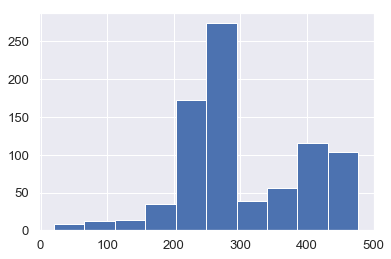

In [63]:
# the number of visitor records per store ranges from 20 to 477
# seems to be two different populations of stores
# 1. stores that have been in the data set from the beginning and have more records
# 2. stores that were added later to the data set and have fewer records
df['air_store_id'].value_counts().hist()
plt.show()

In [64]:
df['visit_date'].describe()

count                  252108
unique                    478
top       2017-03-17 00:00:00
freq                      799
first     2016-01-01 00:00:00
last      2017-04-22 00:00:00
Name: visit_date, dtype: object

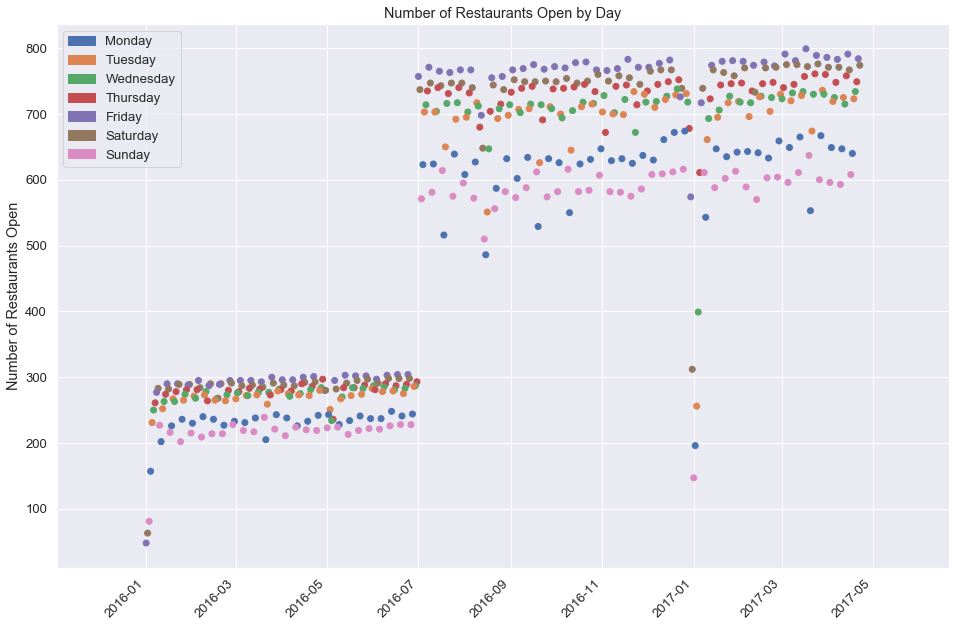

In [65]:
# fewer restaurants in dataset before July 2016
# few restaurants open around new years
# most restaurants open on Friday > Saturday > Thursday > Wednesday/Tuesday >> Monday > Sunday
open_df = vfp.plot_open_stores_daily(df, df['air_store_id'].unique(), title='Number of Restaurants Open by Day')

In [66]:
open_df.describe()

visit_date   visit_dow
count  478.000000  478.000000
mean   527.422594    3.006276
std    220.903759    2.000514
min     48.000000    0.000000
25%    282.250000    1.000000
50%    619.500000    3.000000
75%    730.750000    5.000000
max    799.000000    6.000000

### Missing visit date records

In [67]:
df['air_store_id'].value_counts().tail()

air_1c0b150f9e696a5f    51
air_a17f0778617c76e2    47
air_789103bf53b8096b    41
air_a9a380530c1e121f    40
air_900d755ebd2f7bbd    20
Name: air_store_id, dtype: int64

In [68]:
# visit_date records not guaranteed to be continuous, will need to keep in mind when modeling
df.loc[df['air_store_id'] == 'air_900d755ebd2f7bbd', 'visit_date']

138863   2017-03-02
138864   2017-04-01
138865   2017-04-02
138866   2017-04-04
138867   2017-04-05
138868   2017-04-06
138869   2017-04-07
138870   2017-04-08
138871   2017-04-09
138872   2017-04-11
138873   2017-04-12
138874   2017-04-13
138875   2017-04-14
138876   2017-04-15
138877   2017-04-16
138878   2017-04-18
138879   2017-04-19
138880   2017-04-20
138881   2017-04-21
138882   2017-04-22
Name: visit_date, dtype: datetime64[ns]

### Number of open restaurants based on when they first appeared in the dataset

In [69]:
# big jump in number recorded stores starting July 1, 2016
open_df.loc[(open_df['index'] > '2016-06-23') & (open_df['index'] < '2016-07-07')].sort_values(by='index')

index  visit_date  visit_dow visit_day_name  \
293 2016-06-24         304          4         Friday   
303 2016-06-25         298          5       Saturday   
445 2016-06-26         228          6         Sunday   
420 2016-06-27         244          0         Monday   
344 2016-06-28         286          1        Tuesday   
339 2016-06-29         287          2      Wednesday   
317 2016-06-30         293          3       Thursday   
59  2016-07-01         757          4         Friday   
105 2016-07-02         737          5       Saturday   
280 2016-07-03         571          6         Sunday   
238 2016-07-04         623          0         Monday   
179 2016-07-05         703          1        Tuesday   
162 2016-07-06         714          2      Wednesday   

                                                 color  
293  (0.5058823529411764, 0.4470588235294118, 0.701...  
303  (0.5764705882352941, 0.47058823529411764, 0.37...  
445  (0.8549019607843137, 0.5450980392156862, 0.764...  
420  (0.2980392156862745, 0.4470588235294118, 0.690...  
344  (0.8666666666666667, 0.5176470588235295, 0.321...  
339  (0.3333333333333333, 0.6588235294117647, 0.407...  
317  (0.7686274509803922, 0.3058823529411765, 0.321...  
59   (0.5058823529411764, 0.4470588235294118, 0.701...  
105  (0.5764705882352941, 0.47058823529411764, 0.37...  
280  (0.8549019607843137, 0.5450980392156862, 0.764...  
238  (0.2980392156862745, 0.4470588235294118, 0.690...  
179  (0.8666666666666667, 0.5176470588235295, 0.321...  
162  (0.3333333333333333, 0.6588235294117647, 0.407...

In [70]:
df.head()

air_store_id visit_date  visitors  air_genre_name  \
0  air_00a91d42b08b08d9 2016-07-01        35  Italian/French   
1  air_00a91d42b08b08d9 2016-07-02         9  Italian/French   
2  air_00a91d42b08b08d9 2016-07-04        20  Italian/French   
3  air_00a91d42b08b08d9 2016-07-05        25  Italian/French   
4  air_00a91d42b08b08d9 2016-07-06        29  Italian/French   

                     air_area_name   latitude   longitude prefecture  \
0  Tōkyō-to Chiyoda-ku Kudanminami  35.694003  139.753595   Tōkyō-to   
1  Tōkyō-to Chiyoda-ku Kudanminami  35.694003  139.753595   Tōkyō-to   
2  Tōkyō-to Chiyoda-ku Kudanminami  35.694003  139.753595   Tōkyō-to   
3  Tōkyō-to Chiyoda-ku Kudanminami  35.694003  139.753595   Tōkyō-to   
4  Tōkyō-to Chiyoda-ku Kudanminami  35.694003  139.753595   Tōkyō-to   

         city               city-area  
0  Chiyoda-ku  Chiyoda-ku Kudanminami  
1  Chiyoda-ku  Chiyoda-ku Kudanminami  
2  Chiyoda-ku  Chiyoda-ku Kudanminami  
3  Chiyoda-ku  Chiyoda-ku Kudanminami  
4  Chiyoda-ku  Chiyoda-ku Kudanminami

In [71]:
len(df.loc[df['visit_date'] < '2016-07-01', 'air_store_id'].unique())

316

In [72]:
len(df['air_store_id'].unique())

829

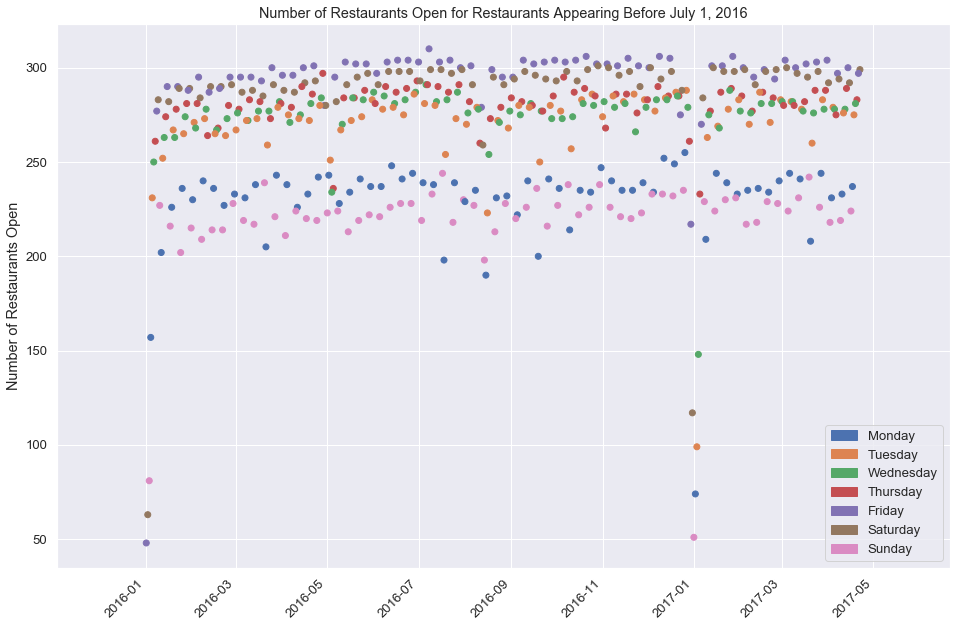

In [73]:
open_before_df = vfp.plot_open_stores_daily(df, vfd.get_stores_before(df),
                                             title='Number of Restaurants Open for Restaurants Appearing Before July 1, 2016')

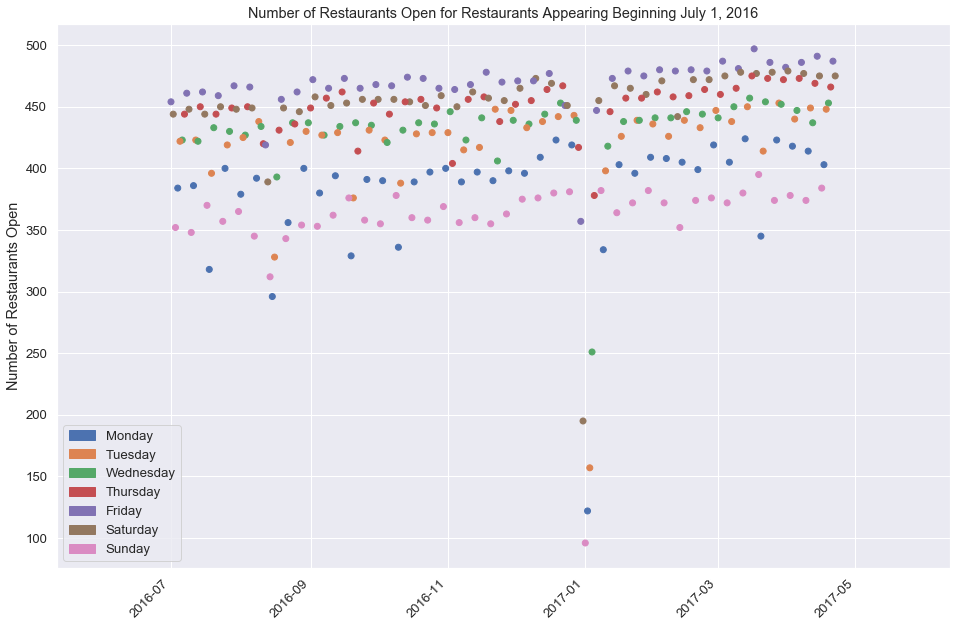

In [74]:
open_after_df = vfp.plot_open_stores_daily(df, vfd.get_stores_starting(df),
                                            title='Number of Restaurants Open for Restaurants Appearing Beginning July 1, 2016')

Both restaurant populations tend to be closed in the first week of the New Year and have the same distribution of open days during the week (Friday > Saturday > Thursday > Wednesday/Tuesday >> Monday > Sunday). There seems to be less of a difference in the later population between the number of restaurants closed on Tuesday and Monday.

In [75]:
open_before_df.describe()

visit_date   visit_dow
count  478.000000  478.000000
mean   265.062762    3.006276
std     37.243156    2.000514
min     48.000000    0.000000
25%    238.250000    1.000000
50%    278.000000    3.000000
75%    290.000000    5.000000
max    310.000000    6.000000

In [76]:
open_after_df.describe()

visit_date   visit_dow
count  296.000000  296.000000
mean   423.675676    3.010135
std     53.040402    2.000822
min     96.000000    0.000000
25%    396.750000    1.000000
50%    438.000000    3.000000
75%    457.000000    5.000000
max    497.000000    6.000000

In [77]:
len(vfd.get_stores_before(df))

316

In [78]:
len(vfd.get_stores_starting(df))

513

There is a group of 316 stores which have been present in the dataset before July 2016 and a group of 513 stores which were added to the dataset starting July 2016. 

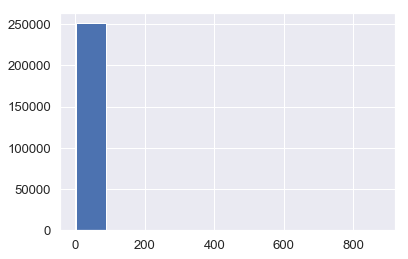

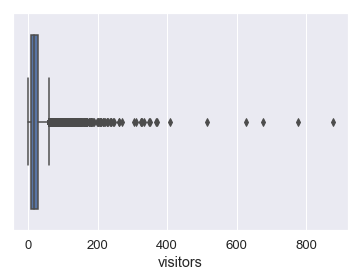

In [79]:
df['visitors'].hist()
plt.show()

sns.boxplot(df['visitors'])
plt.show()

In [80]:
# the number of visitors varies greatly from 1 to 877
# extremely right skewed
df['visitors'].describe()

count    252108.000000
mean         20.973761
std          16.757007
min           1.000000
25%           9.000000
50%          17.000000
75%          29.000000
max         877.000000
Name: visitors, dtype: float64

In [81]:
before_df = vfd.get_stores_before_df(df)
after_df = vfd.get_stores_starting_df(df)

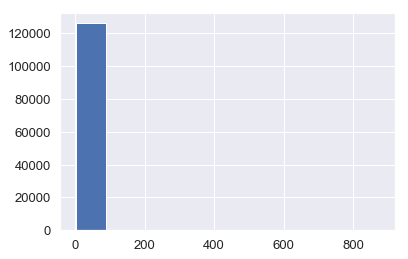

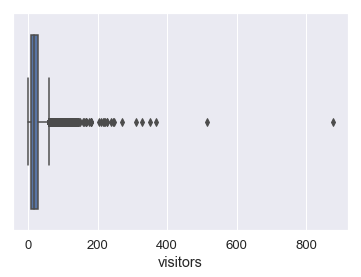

In [82]:
before_df['visitors'].hist()
plt.show()

sns.boxplot(before_df['visitors'])
plt.show()

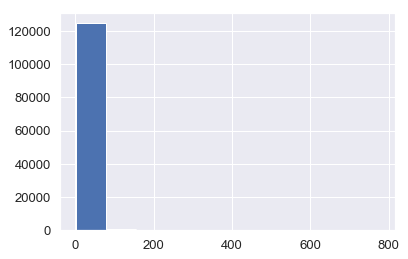

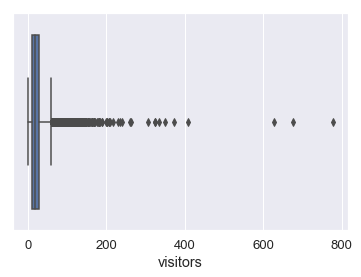

In [83]:
after_df['visitors'].hist()
plt.show()

sns.boxplot(after_df['visitors'])
plt.show()

The distribution of visitors seems similar between the two store populations.

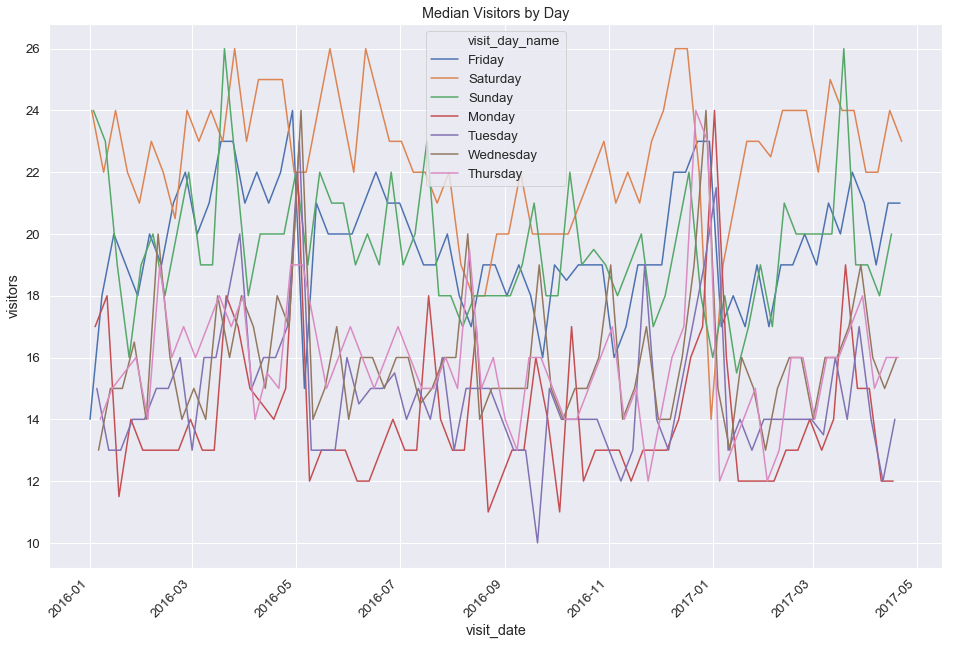

In [84]:
visitors_df = vfp.plot_median_visitors_daily(df, stores_subset=None, title='Median Visitors by Day')

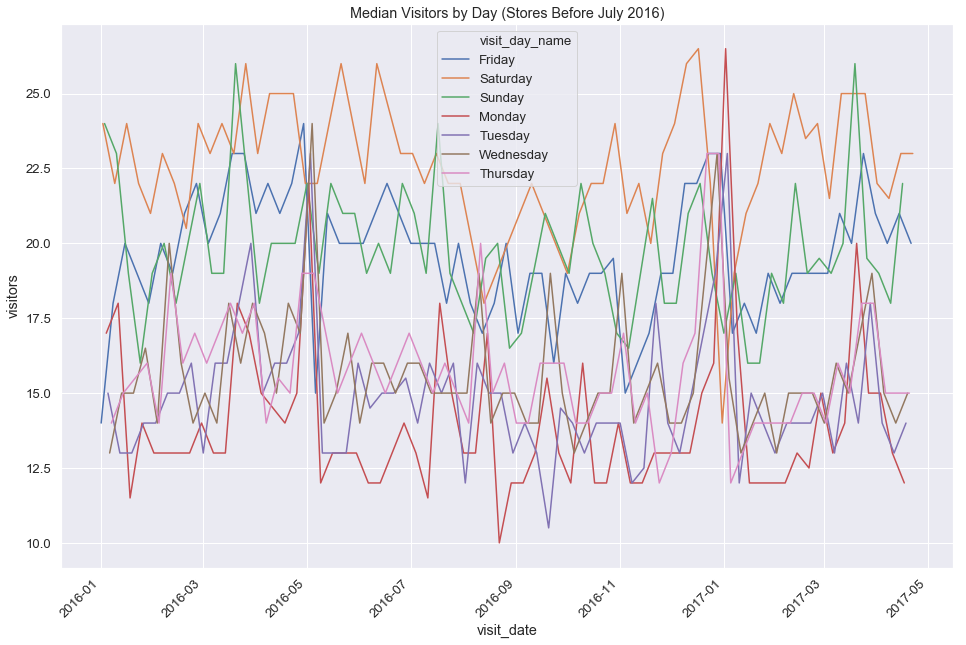

In [85]:
visitors_before_df = vfp.plot_median_visitors_daily(df, stores_subset=vfd.get_stores_before(df),
                                                     title='Median Visitors by Day (Stores Before July 2016)')

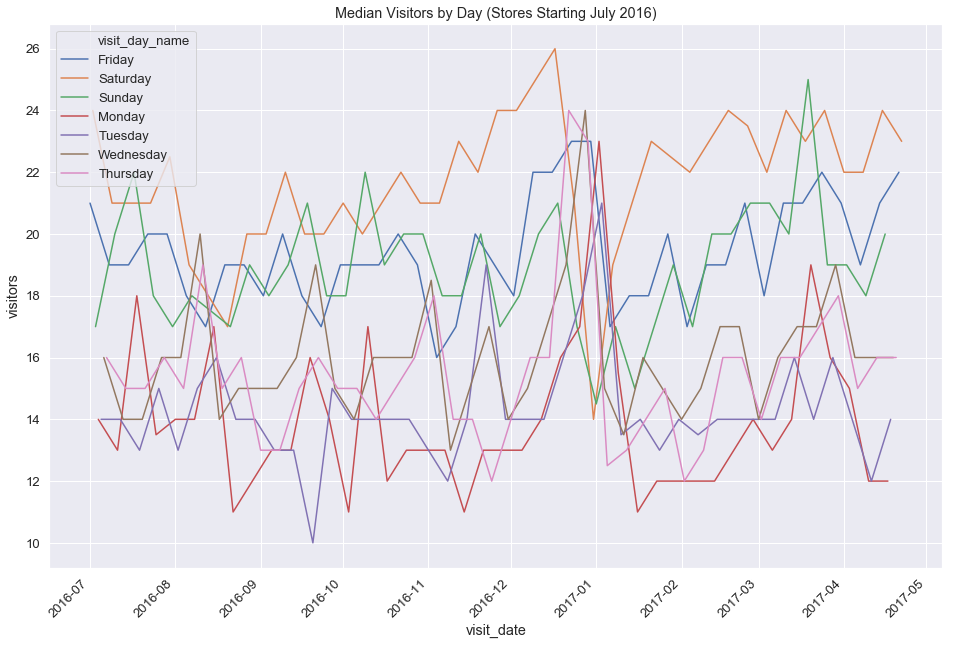

In [86]:
visitors_after_df = vfp.plot_median_visitors_daily(df, stores_subset=vfd.get_stores_starting(df),
                                                     title='Median Visitors by Day (Stores Starting July 2016)')

In [87]:
visitors_df.groupby(by='visit_day_name')['visitors'].describe().sort_values(by='50%')

count       mean       std   min     25%   50%     75%   max
visit_day_name                                                              
Monday           68.0  14.044118  2.429199  11.0  13.000  13.0  15.000  24.0
Tuesday          68.0  14.779412  2.149943  10.0  13.375  14.0  15.625  23.0
Wednesday        68.0  15.941176  2.134523  13.0  15.000  15.5  16.125  24.0
Thursday         68.0  15.816176  2.114104  12.0  15.000  16.0  17.000  24.0
Friday           69.0  19.644928  1.979865  14.0  19.000  19.0  21.000  24.0
Sunday           68.0  19.558824  2.074237  15.5  18.000  19.0  20.000  26.0
Saturday         69.0  22.442029  2.163426  14.0  21.000  22.5  24.000  26.0

In [88]:
visitors_before_df.groupby(by='visit_day_name')['visitors'].describe().sort_values(by='50%')

count       mean       std   min   25%    50%   75%   max
visit_day_name                                                           
Monday           68.0  14.014706  2.649937  10.0  12.0  13.00  15.0  26.5
Tuesday          68.0  14.845588  2.234828  10.5  13.0  14.25  16.0  23.0
Wednesday        68.0  15.676471  2.127932  13.0  14.0  15.00  16.0  24.0
Thursday         68.0  15.764706  2.057876  12.0  14.0  15.25  17.0  23.0
Sunday           68.0  19.735294  2.143144  16.0  19.0  19.00  21.0  26.0
Friday           69.0  19.586957  2.073922  14.0  18.0  20.00  21.0  24.0
Saturday         69.0  22.565217  2.157260  14.0  21.5  23.00  24.0  26.5

In [89]:
visitors_after_df.groupby(by='visit_day_name')['visitors'].describe().sort_values(by='50%')

count       mean       std   min     25%   50%    75%   max
visit_day_name                                                             
Monday           42.0  13.904762  2.435104  11.0  12.000  13.0  14.75  23.0
Tuesday          42.0  14.285714  1.821762  10.0  13.625  14.0  14.00  21.0
Thursday         42.0  15.464286  2.384894  12.0  14.000  15.0  16.00  24.0
Wednesday        42.0  16.023810  2.045079  13.0  15.000  16.0  17.00  24.0
Friday           43.0  19.418605  1.735245  16.0  18.000  19.0  21.00  23.0
Sunday           42.0  18.857143  1.960854  14.5  17.625  19.0  20.00  25.0
Saturday         43.0  21.686047  2.228130  14.0  21.000  22.0  23.00  26.0

The distribution of visitors seems similar between the two restaurant populations. Friday, Saturday, and Sunday have higher 
median visitors. There seems to be a weekly seasonality to the number of visitors.

In [90]:
# From Wikipedia:
# Izakaya: "a type of informal Japanese pub"
# Okonomiyaki/Monja/Teppanyaki: foods cooked on an iron plate
# Yakiniku: "grilled meat cuisine"
df['air_genre_name'].unique()

array(['Italian/French', 'Izakaya', 'Dining bar', 'Cafe/Sweets',
       'Japanese food', 'Western food', 'Okonomiyaki/Monja/Teppanyaki',
       'Other', 'Yakiniku/Korean food', 'Asian', 'Bar/Cocktail',
       'Creative cuisine', 'International cuisine', 'Karaoke/Party'],
      dtype=object)

In [91]:
len(df['air_genre_name'].unique())

14

In [92]:
# two new restaurant genres were introduced to the dataset starting July 2016
set(after_df['air_genre_name'].unique()).difference(set(before_df['air_genre_name'].unique()))

{'International cuisine', 'Karaoke/Party'}

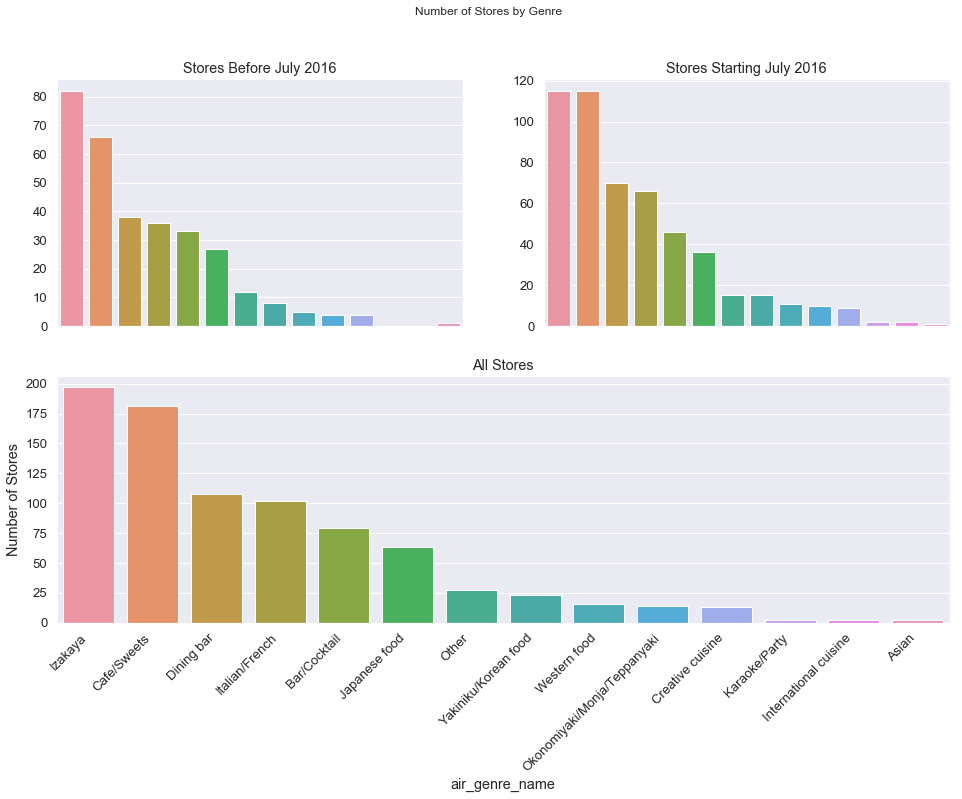

In [93]:
vfp.plot_store_counts_comparison(df, 'air_genre_name', title='Number of Stores by Genre')

Izakaya and Cafe/Sweets restaurants are the most represented genres of restaurants. The distribution of genres is similar between the two population of stores.

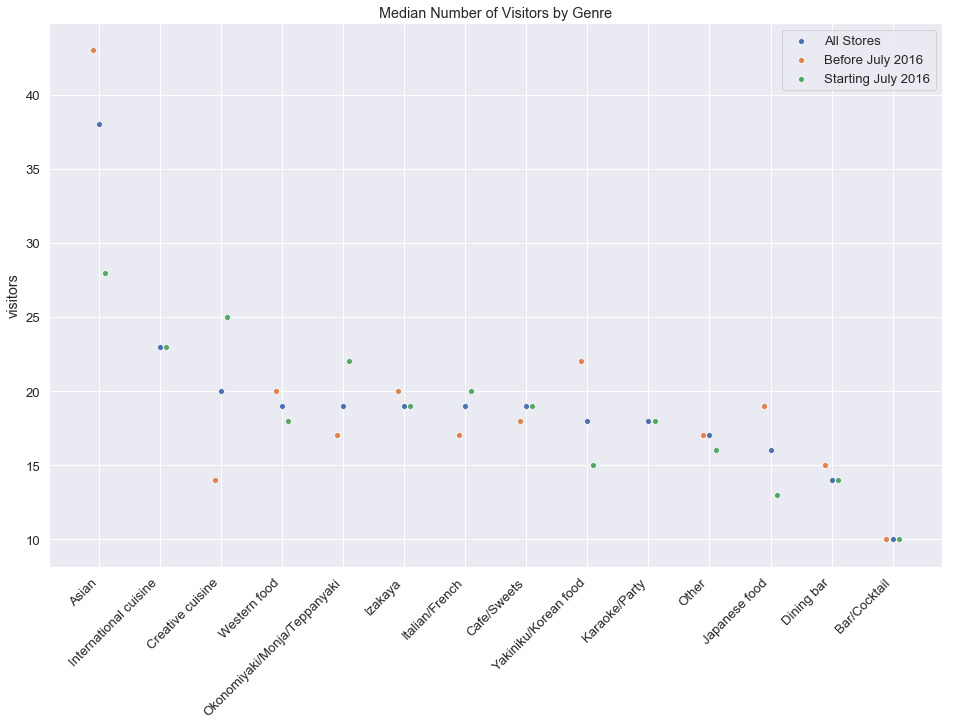

In [94]:
vfp.plot_median_visitors_comparison(df, 'air_genre_name', title='Median Number of Visitors by Genre')

The median number of visitors by genre may differ for some genres between the two populations of restaurants.

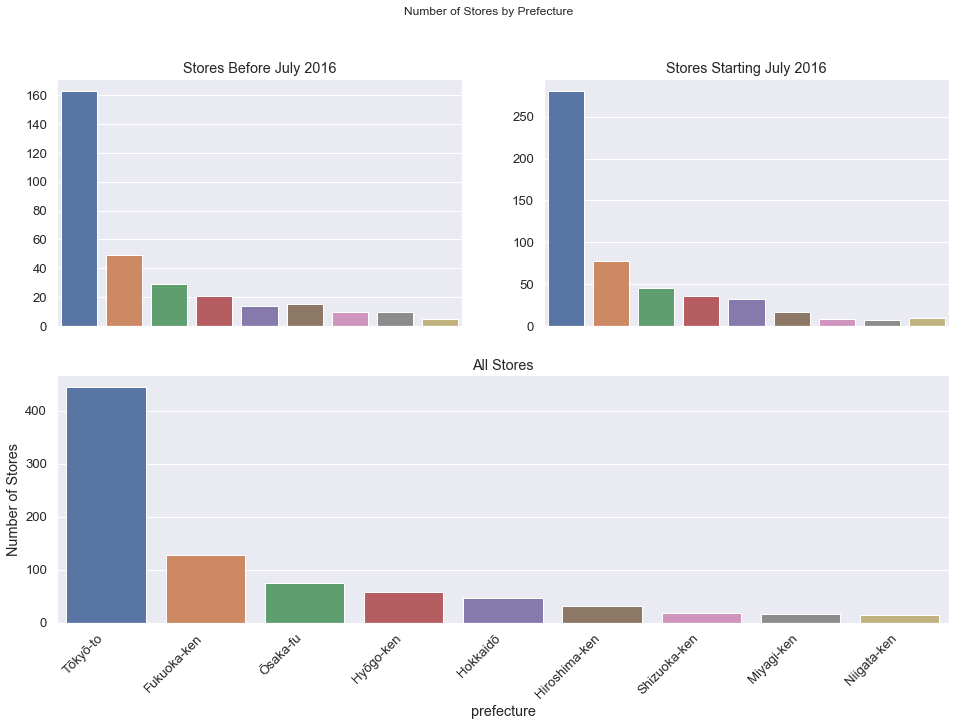

In [95]:
vfp.plot_store_counts_comparison(df, 'prefecture', title='Number of Stores by Prefecture')

The distribution of stores by prefecture seems similar between the two restaurant populations. Most restaurants are in Tokyo.

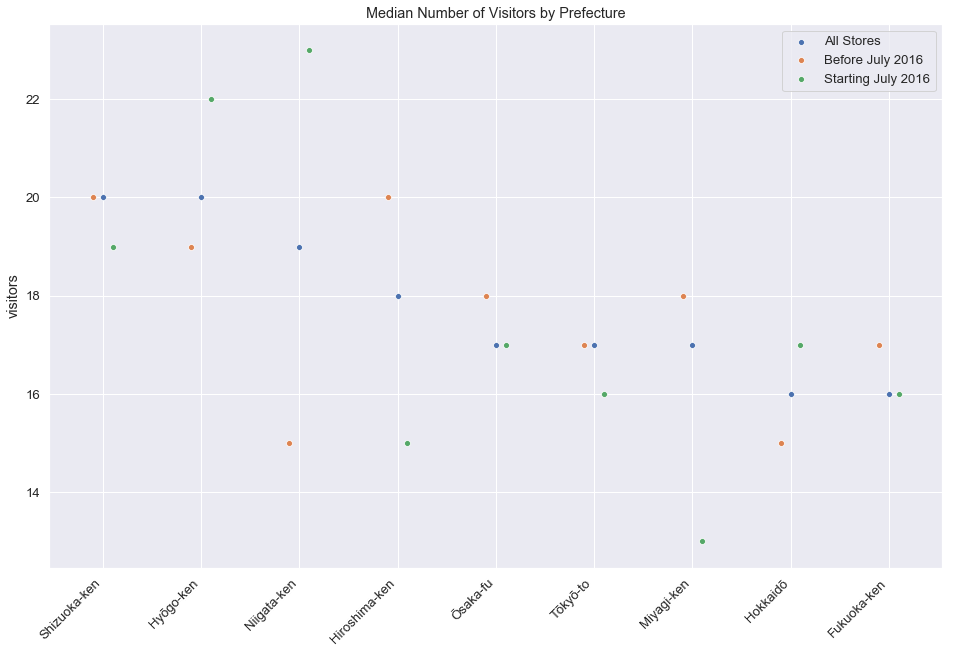

In [96]:
vfp.plot_median_visitors_comparison(df, 'prefecture', title='Median Number of Visitors by Prefecture')

There may be a difference in median number of visitors by prefecture between the two restaurant populations.

In [97]:
df.loc[df['prefecture'] == 'Tōkyō-to', 'city'].nunique()

26

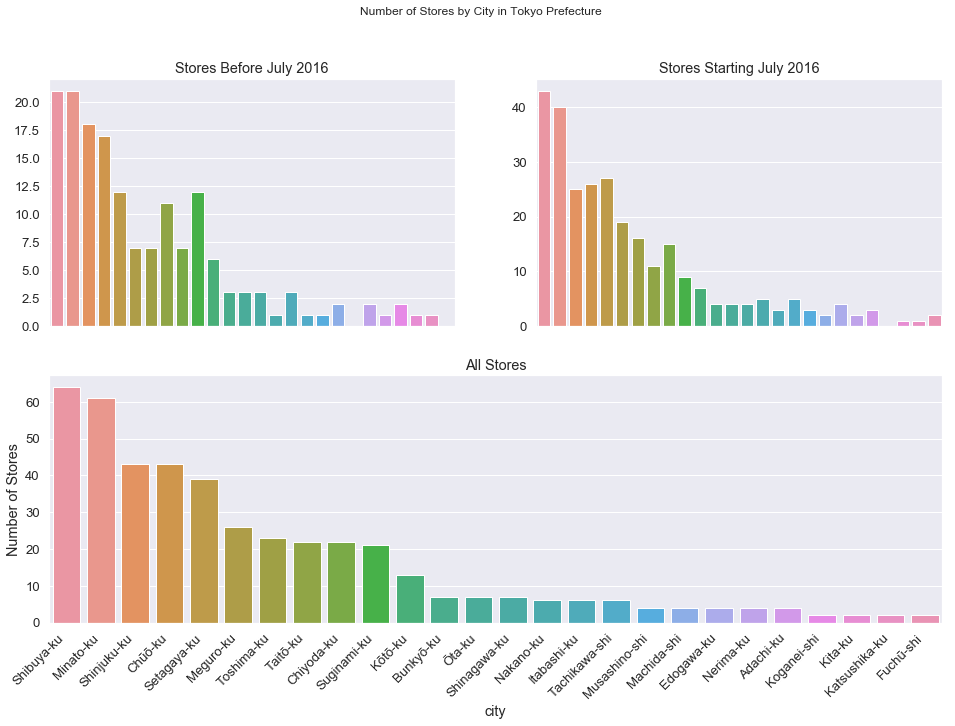

In [98]:
vfp.plot_store_counts_comparison(df.loc[df['prefecture'] == 'Tōkyō-to', :], 'city',
                                 title='Number of Stores by City in Tokyo Prefecture')

The distribution of stores seems to differ between the two restaurant populations. Shibuya and Minato have the highest number of stores.

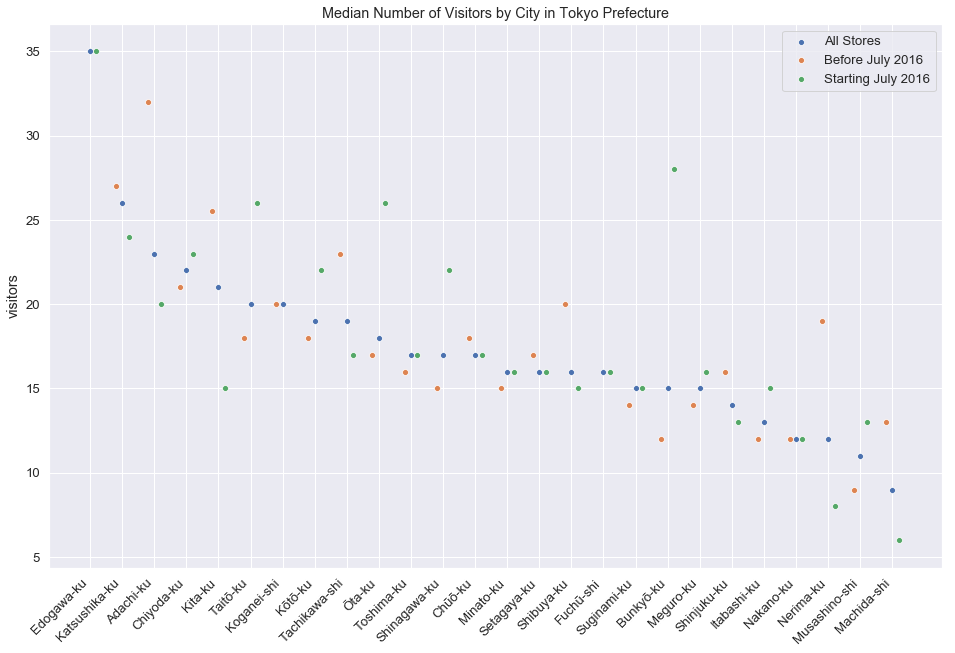

In [99]:
vfp.plot_median_visitors_comparison(df.loc[df['prefecture'] == 'Tōkyō-to', :], 'city',
                                    title='Median Number of Visitors by City in Tokyo Prefecture')

There may be a difference in median number of visitors by city between the two restaurant populations.

In [100]:
df.loc[(df['prefecture'] == 'Tōkyō-to') & (df['city'].isin(['Shibuya-ku', 'Minato-ku'])), 'city-area'].nunique()

7

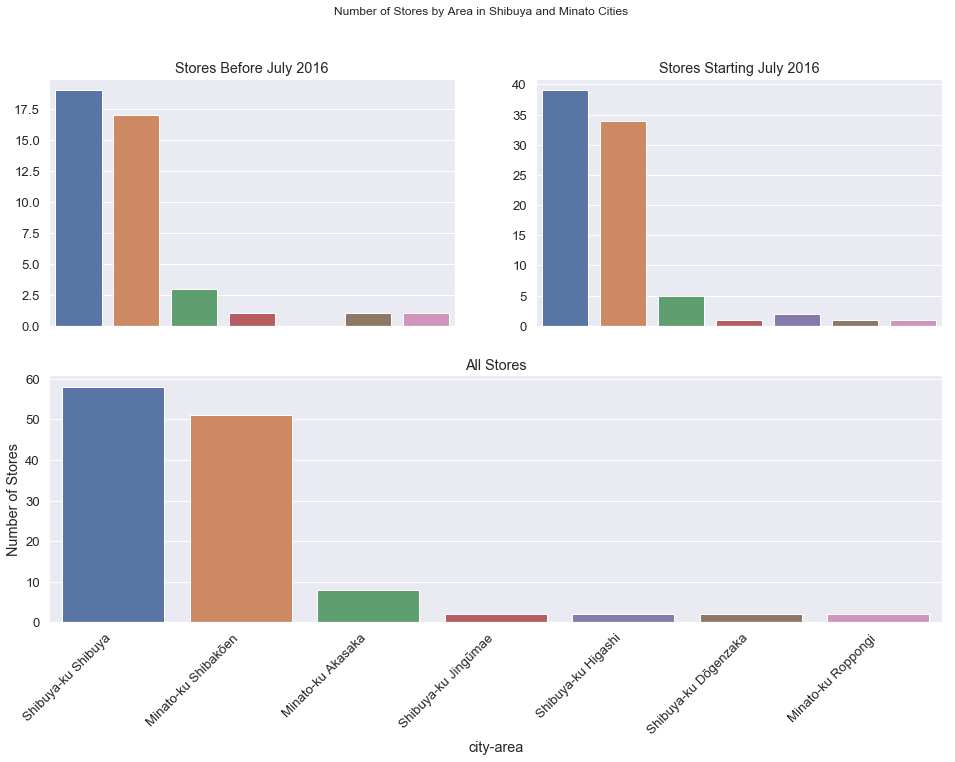

In [101]:
vfp.plot_store_counts_comparison(df.loc[(df['prefecture'] == 'Tōkyō-to') & (df['city'].isin(['Shibuya-ku', 'Minato-ku'])), :],
                                 'city-area',
                                 title='Number of Stores by Area in Shibuya and Minato Cities')

The distribution of stores seems to be similar between the two restaurant populations. Shibuya and Shibakoen areas have the highest number of stores.

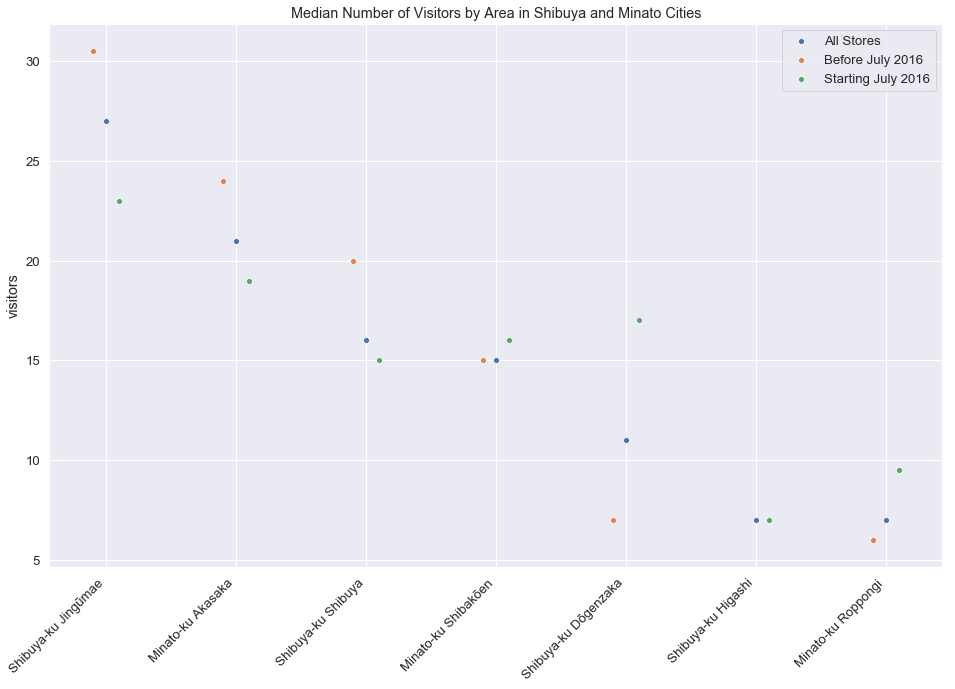

In [102]:
vfp.plot_median_visitors_comparison(df.loc[(df['prefecture'] == 'Tōkyō-to') & (df['city'].isin(['Shibuya-ku', 'Minato-ku'])), :],
                                    'city-area',
                                    title='Median Number of Visitors by Area in Shibuya and Minato Cities')

The median number of visitors seems to differ for some areas.

The most common restaurants are Izakaya and Cafe/Sweets types in the Shibuya and Shibakōen areas of the Shibuya-ku and Minato-ku cities within Tōkyō-to prefecture.

# Continued in the next notebook